We want payoff function 
$$payoff = \max\{x_1 - x_2 -\kappa, 0\}

# Distribution

In [328]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3
num_qubits_for_each_dimension = num_uncertainty_qubits + 1

# # parameters for considered random distribution
# T = 40 / 365  # 40 days to maturity

# # first variable
# S1 = 2.0 # initial spot price
# vol1 = 0.4  # volatility of 40%
# r1 = 0.04  # annual interest rate of 4%

# # resulting parameters for log-normal distribution
# mu1 = (r1 - 0.5 * vol1**2) * T + np.log(S1)
# sigma1 = vol1 * np.sqrt(T)
# mean1 = np.exp(mu1 + sigma1**2 / 2)
# variance1 = (np.exp(sigma1**2) - 1) * np.exp(2 * mu1 + sigma1**2)
# stddev1 = np.sqrt(variance1)

# # second variable
# S2 = 1.8 # initial spot price
# vol2 = 0.3  # volatility of 30%
# r2 = 0.05  # annual interest rate of 5%

# # resulting parameters for log-normal distribution
# mu2 = (r2 - 0.5 * vol2**2) * T + np.log(S2)
# sigma2 = vol2 * np.sqrt(T)
# mean2 = np.exp(mu2 + sigma2**2 / 2)
# variance2 = (np.exp(sigma2**2) - 1) * np.exp(2 * mu2 + sigma2**2)
# stddev2 = np.sqrt(variance2)

# # lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
# # low = np.maximum(0, mean - 3 * stddev)
# low = 0
# high = max(mean1 + 3 * stddev1, mean2 + 3 * stddev2)

# # map to higher dimensional distribution
# # for simplicity assuming dimensions are independent and identically distributed)
# dimension = 2
# num_qubits = [num_uncertainty_qubits] * dimension
# low = low * np.ones(dimension)
# high = high * np.ones(dimension)
# mu = [mu1, mu2]
# cov = np.diag([sigma1**2, sigma2**2]) # covariance matrix


# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = 0
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix


# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))

In [329]:
u.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │  P(X) │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     └───────┘

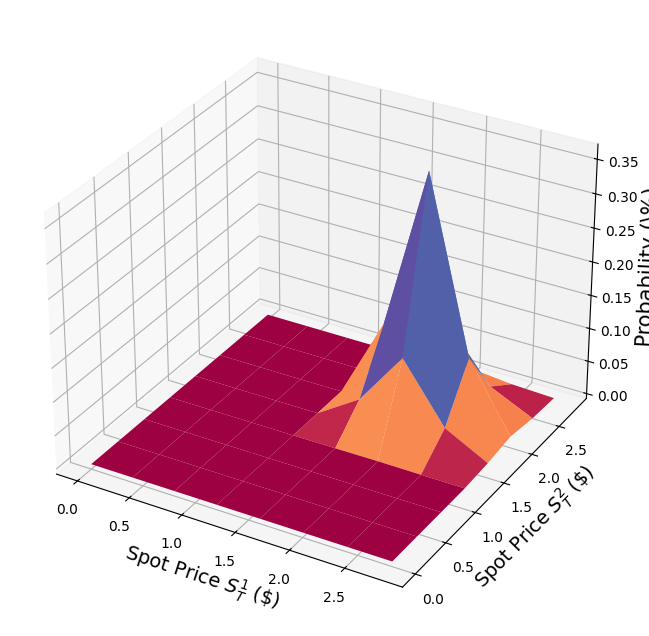

In [330]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# plot PDF of uncertainty model
x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities
# z = map(float, z)
# z = list(map(float, z))
resolution = np.array([2**n for n in num_qubits]) * 1j
grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_T^1$ (\$)", size=14)
ax.set_ylabel("Spot Price $S_T^2$ (\$)", size=14)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()

In [331]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.circuit.library import VBERippleCarryAdder

firstRegister = QuantumRegister(num_qubits_for_each_dimension, 'first')
secondRegister = QuantumRegister(num_qubits_for_each_dimension, 'second')
carryRegister = QuantumRegister(1, 'carry')
ancillaRegister = QuantumRegister(num_qubits_for_each_dimension, 'ancilla')

adder = VBERippleCarryAdder(num_qubits_for_each_dimension, name="Adder")
num_qubits = len(adder.qubits)

circ = QuantumCircuit(carryRegister, firstRegister, secondRegister, ancillaRegister)
circ.x(secondRegister)
circ.x(carryRegister)
circ.append(adder, list(range(num_qubits)))
circ.draw()



┌───┐┌─────────┐
    carry: ┤ X ├┤0        ├
           └───┘│         │
  first_0: ─────┤1        ├
                │         │
  first_1: ─────┤2        ├
                │         │
  first_2: ─────┤3        ├
                │         │
  first_3: ─────┤4        ├
           ┌───┐│         │
 second_0: ┤ X ├┤5        ├
           ├───┤│         │
 second_1: ┤ X ├┤6  Adder ├
           ├───┤│         │
 second_2: ┤ X ├┤7        ├
           ├───┤│         │
 second_3: ┤ X ├┤8        ├
           └───┘│         │
ancilla_0: ─────┤9        ├
                │         │
ancilla_1: ─────┤10       ├
                │         │
ancilla_2: ─────┤11       ├
                │         │
ancilla_3: ─────┤12       ├
                └─────────┘

In [362]:
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 0.7

# map strike price from [low, high] to {0, ..., 2^n-1}
max_value = 2**(num_qubits_for_each_dimension) -1
low_ = low[0]
high_ = high[0]
mapped_strike_price = (
    (strike_price - dimension * low_) / (high_ - low_) * (2**(num_uncertainty_qubits) - 1)
)
print(max_value)
print(mapped_strike_price)
# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [0, mapped_strike_price, 2**num_uncertainty_qubits-1]
slopes = [0, 1, 0]
offsets = [0, 0, -(2**num_uncertainty_qubits-1-mapped_strike_price)]

f_min = 0
f_max = 2**(num_uncertainty_qubits)-1 - mapped_strike_price

spread_objective = LinearAmplitudeFunction(
    num_qubits_for_each_dimension,
    slopes,
    offsets,
    domain=(0, max_value),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)


15
1.7435927506786155


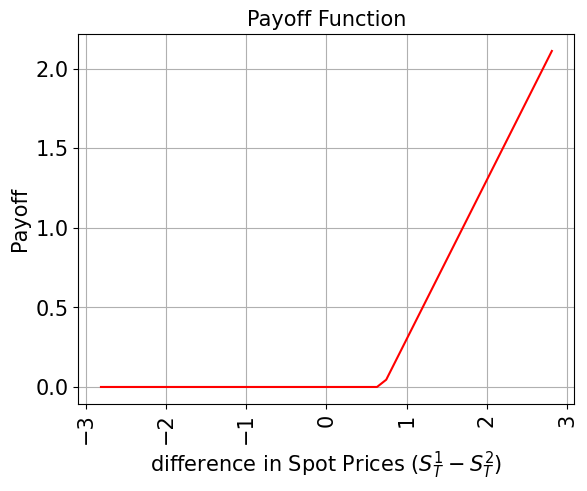

In [363]:
import matplotlib.pyplot as plt
x = np.linspace(low[0]-high[0], high[0])
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "r-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("difference in Spot Prices ($S_T^1 - S_T^2)$", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [364]:
# from qiskit.circuit.library import WeightedAdder, LinearAmplitudeFunction

# # determine number of qubits required to represent total loss
# num_qubits = [num_qubits_for_each_dimension] * dimension
# weights = []
# for n in num_qubits:
#     for i in range(n):
#         weights += [2**i]
# # we can see that weights is according to the binary representation of the number
# print(weights)

In [365]:
# create aggregation circuit
# agg = WeightedAdder(sum(num_qubits), weights) # integer weights only
# n_s = agg.num_sum_qubits
# n_aux = agg.num_qubits - n_s - agg.num_state_qubits  # number of additional qubits
# agg.draw()

In [366]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit
# define overall multivariate problem

firstRegister = QuantumRegister(num_qubits_for_each_dimension, 'first')
secondRegister = QuantumRegister(num_qubits_for_each_dimension, 'second')
objectiveRegister = QuantumRegister(1, 'obj')
carryRegister = QuantumRegister(1, 'carry')
ancillaRegister = AncillaRegister(max(num_qubits_for_each_dimension, spread_objective.num_ancillas), 'ancilla')
# optionAncillaRegister = AncillaRegister(spread_objective.num_ancillas, 'optionAncilla')

objective_index = num_qubits_for_each_dimension*2

spread_option = QuantumCircuit(carryRegister, firstRegister, secondRegister, ancillaRegister, objectiveRegister)
spread_option.append(u, firstRegister[:-1] + secondRegister[:-1])
spread_option.append(circ, carryRegister[:] + firstRegister[:]+ secondRegister[:] + ancillaRegister[:])
spread_option.append(spread_objective, secondRegister[:] + objectiveRegister[:] + ancillaRegister[:spread_objective.num_ancillas])

spread_option.draw()

┌─────────────────┐      
    carry: ─────────┤0                ├──────
           ┌───────┐│                 │      
  first_0: ┤0      ├┤1                ├──────
           │       ││                 │      
  first_1: ┤1      ├┤2                ├──────
           │       ││                 │      
  first_2: ┤2      ├┤3                ├──────
           │       ││                 │      
  first_3: ┤  P(X) ├┤4                ├──────
           │       ││                 │┌────┐
 second_0: ┤3      ├┤5                ├┤0   ├
           │       ││                 ││    │
 second_1: ┤4      ├┤6  circuit-21333 ├┤1   ├
           │       ││                 ││    │
 second_2: ┤5      ├┤7                ├┤2   ├
           └───────┘│                 ││    │
 second_3: ─────────┤8                ├┤3   ├
                    │                 ││    │
ancilla_0: ─────────┤9                ├┤5 F ├
                    │                 ││    │
ancilla_1: ─────────┤10               ├┤6   ├
                    │                 ││    │
ancilla_2: ─────────┤11               ├┤7   ├
                    │                 ││    │
ancilla_3: ─────────┤12               ├┤8   ├
                    └─────────────────┘│    │
      obj: ────────────────────────────┤4   ├
                                       └────┘

In [367]:
print(u.values)

[(0.0, 0.0), (0.0, 0.40146989583866777), (0.0, 0.8029397916773355), (0.0, 1.2044096875160033), (0.0, 1.605879583354671), (0.0, 2.007349479193339), (0.0, 2.4088193750320066), (0.0, 2.8102892708706744), (0.40146989583866777, 0.0), (0.40146989583866777, 0.40146989583866777), (0.40146989583866777, 0.8029397916773355), (0.40146989583866777, 1.2044096875160033), (0.40146989583866777, 1.605879583354671), (0.40146989583866777, 2.007349479193339), (0.40146989583866777, 2.4088193750320066), (0.40146989583866777, 2.8102892708706744), (0.8029397916773355, 0.0), (0.8029397916773355, 0.40146989583866777), (0.8029397916773355, 0.8029397916773355), (0.8029397916773355, 1.2044096875160033), (0.8029397916773355, 1.605879583354671), (0.8029397916773355, 2.007349479193339), (0.8029397916773355, 2.4088193750320066), (0.8029397916773355, 2.8102892708706744), (1.2044096875160033, 0.0), (1.2044096875160033, 0.40146989583866777), (1.2044096875160033, 0.8029397916773355), (1.2044096875160033, 1.2044096875160033

In [368]:
# evaluate exact expected value
sum_values = np.array([v[0]-v[1] for v in u.values])
exact_value = np.dot(
    u.probabilities[sum_values >= strike_price],
    sum_values[sum_values >= strike_price] - strike_price,
)
print("exact expected value:\t%.4f" % exact_value)

exact expected value:	0.0063


In [373]:
# set target precision and confidence level
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from ModifiedIQAE.algorithms.amplitude_estimators.mod_iae import ModifiedIterativeAmplitudeEstimation
from qiskit_algorithms import EstimationProblem
from qiskit_algorithms import IterativeAmplitudeEstimation
from qiskit_aer.primitives import Sampler

epsilon = 0.01
alpha = 0.005

problem = EstimationProblem(
    state_preparation=spread_option,
    objective_qubits=[objective_index],
    post_processing=spread_objective.post_processing,
)
# construct amplitude estimation

# qi = QuantumInstance(backend=AerSimulator(), shots=200)
# ae = ModifiedIterativeAmplitudeEstimation(
#     epsilon_target=epsilon, alpha=alpha, quantum_instance=qi)
# result = ae.estimate(problem, shots=200)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
)
result = ae.estimate(problem)

In [374]:
print(result)

{   'alpha': 0.005,
    'circuit_results': None,
    'confidence_interval': (0.2777031735036602, 0.28332565580799934),
    'confidence_interval_processed': (   -0.34731301072820814,
                                         -0.27205422322133244),
    'epsilon_estimated': 0.0028112411521695746,
    'epsilon_estimated_processed': 0.03762939375343785,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.11529580480980184, 0.4063811788420776],
                              [0.1512907499156868, 0.3592966829709682],
                              [0.15694807261097435, 0.32408942819403397],
                              [0.2551691162118223, 0.3175799751416247],
                              [0.271591830781969, 0.29226662378461227],
                              [0.2777031735036602, 0.28332565580799934]],
    'estimation': 0.28051441465582977,
    'estimation_processed': -0.3096836169747703,
    'num_oracle_queries': 3600,
    'powers': [0, 0, 0,

In [375]:
conf_int = (
    np.array(result.confidence_interval_processed)
    / (2**(num_uncertainty_qubits) - 1)
    * (high_ - low_)
)
print("Exact value:        \t%.4f" % exact_value)
print(
    "Estimated value:    \t%.4f"
    % (result.estimation_processed / (2**num_uncertainty_qubits - 1) * (high_ - low_))
)
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.0063
Estimated value:    	-0.1243
Confidence interval:	[-0.1394, -0.1092]
